## **Análisis de Series de Tiempo - Trabajo Final**

## Gustavo Uñapillco       Código: a1624



## **Primera Parte**

### a. Limpieza y Preparación de Datos


In [16]:
#IMPORTACIÓN DE LIBRERÍAS 

# -------------------------
# Utilidades generales
# -------------------------
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Manejo y procesamiento de datos
# -------------------------
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Visualización
# -------------------------
import matplotlib.pyplot as plt

# -------------------------
# Calendario de mercados
# -------------------------
import pandas_market_calendars as mcal

# -------------------------
# Estadística y series temporales
# -------------------------
##from statsmodels.tsa.stattools import adfuller
##from statsmodels.graphics.tsaplots import plot_predict
##from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.tsa.arima.model import ARIMA as sm_ARIMA
##from statsmodels.tsa.seasonal import seasonal_decompose
##from pmdarima.arima import ARIMA as pm_ARIMA
##import pmdarima as pm
##from arch import arch_model

# -------------------------
# Modelado con LSTM
# -------------------------
##from keras.models import Sequential
##from keras.layers import LSTM, Dense, Dropout
##from keras.preprocessing.sequence import TimeseriesGenerator

# -------------------------
# Paralelización
# -------------------------
##from joblib import parallel_backend


In [17]:
#INSTALACIÓN DE LIBRERÍAS
#!pip install tabulate pandas_market_calendars pmdarima arch

#### 1. Carga del dataframe diario

In [18]:
def load_or_generate_parquet():
    #path = '0_preprocesamiento_datos/mnq_intraday_data.parquet' 
    archivo = './mnq_intraday_data.parquet'

    if os.path.exists(archivo):
        print("Archivo encontrado. Cargando DataFrame desde disco...")
        mnq_intraday = pd.read_parquet(archivo)
        
    return mnq_intraday

In [19]:
mnq_intraday = load_or_generate_parquet()

Archivo encontrado. Cargando DataFrame desde disco...


In [20]:
mnq_intraday.head()

,open,high,low,close,volume
datetime,,,,,
2019-12-23 08:30:00-05:00,8736.25,8737.50,8736.25,8737.00,30
2019-12-23 08:31:00-05:00,8737.00,8737.25,8736.00,8736.50,45
2019-12-23 08:32:00-05:00,8736.50,8736.75,8735.50,8736.00,73
2019-12-23 08:33:00-05:00,8736.50,8736.75,8736.00,8736.75,51
2019-12-23 08:34:00-05:00,8736.75,8739.00,8736.75,8737.75,91


#### 2. Búsqueda de ALPHA FACTOR    

Un alpha factor es como una hipótesis cuantitativa: propone que una cierta transformación de los datos (por ejemplo, un RSI bajo o un volumen inusualmente alto) podría anticipar un movimiento futuro del precio.

Entonces, antes de entrenar un modelo LSTM, XGBoost o cualquier otro, el alpha factor te ayuda a descubrir cuáles features tienen “potencial predictivo”

Primero veamos cuantas muestras tengo en total:


**¿Qué hace realmente?**

- Evalúa si una variable (feature) tiene relación estadística con el retorno futuro.
- Te filtra las señales útiles del ruido.
- Acelera la selección de features sin tener que probar todo con modelos complejos primero.

Por ejemplo:

- Calculás el momentum 10 y ves que cuando es alto, el retorno a 5 minutos tiende a ser positivo → ese factor tiene alpha.
- Calculás el RSI 14 y no ves ninguna relación → ese factor no tiene alpha (en ese timeframe).

##### 2.1. Añado indicadores técnicos

In [48]:
from ta.momentum import StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange

In [21]:
import pandas as pd
import ta

# Suponiendo que tu DataFrame se llama mnq_intraday
# y tiene columnas: ['datetime', 'open', 'high', 'low', 'close', 'volume']
# y un índice datetime, o una columna separada de fecha

# Asegurar que el índice esté en formato datetime (por si acaso)
mnq_intraday.index = pd.to_datetime(mnq_intraday.index)

# Crear una columna 'date' a partir del índice
mnq_intraday['date'] = mnq_intraday.index.date

In [49]:
# Función para calcular los factores en un solo día
def compute_factors(df_day):
    # Se crea una copia del DataFrame del día para no modificar el original.
    df_day = df_day.copy() 

    '''📊 RSI (Relative Strength Index): mide la fuerza relativa del precio en los últimos períodos. Oscila entre 0 y 100.
            Un valor alto indica sobrecompra, bajo indica sobreventa.
            Aquí se calcula sobre los precios de cierre del día actual.
            Es útil para detectar posibles puntos de reversión.
            '''
    df_day['rsi_14'] = ta.momentum.RSIIndicator(df_day['close']).rsi()
    df_day['rsi_7'] = ta.momentum.RSIIndicator(df_day['close'], window=7).rsi()
    df_day['rsi_5'] = ta.momentum.RSIIndicator(df_day['close'], window=5).rsi()
    df_day['rsi_3'] = ta.momentum.RSIIndicator(df_day['close'], window=3).rsi()

    
    '''⚡ Momentum de 10 minutos: mide la variación porcentual entre el precio actual y el de hace 10 minutos.
            Si es positivo, hubo una suba reciente → posible continuación alcista.
            Si es negativo, indica presión bajista reciente.
        '''
    df_day['momentum_10'] = df_day['close'].pct_change(10)
    df_day['momentum_5'] = df_day['close'].pct_change(5)
    df_day['momentum_3'] = df_day['close'].pct_change(3)

    '''📈 Relación de volumen actual contra su promedio de 20 minutos:
            Si >1: volumen superior al promedio reciente → podría reflejar interés o movimientos institucionales.
            Si <1: volumen bajo → señal de menor actividad o consolidación.
            Es una forma de capturar spikes de volumen sin usar el volumen en crudo.
        '''
    df_day['volume_ratio'] = df_day['volume'] / df_day['volume'].rolling(20).mean()

    '''🌀 MACD diferencial (señal de cruce): mide la diferencia entre la línea MACD y su señal (una media de sí misma).
            Cuando es positivo y creciente → momentum alcista.
            Cuando es negativo → momentum bajista.
            Muy usado para detectar giros de tendencia.
        '''
    df_day['macd'] = ta.trend.MACD(df_day['close']).macd_diff()

    '''📏 Distancia del precio actual a su EMA(20):
            Es un indicador de sobreextensión o retorno a la media.
            Si el precio está muy por encima de la EMA → posible reversión o aceleración.
            Este valor se expresa en forma de porcentaje relativo.
        '''
    df_day['price_ema20'] = df_day['close'] / df_day['close'].ewm(span=20).mean() - 1

# 🔄 Indicadores adicionales:
    
    # %K del Estocástico
    stoch = StochasticOscillator(df_day['high'], df_day['low'], df_day['close'], window=14, smooth_window=3)
    df_day['stoch_k'] = stoch.stoch()

    # Bollinger Band %B
    bb = BollingerBands(close=df_day['close'], window=20, window_dev=2)
    df_day['bb_percent'] = bb.bollinger_pband()

    # ATR normalizado
    atr = AverageTrueRange(high=df_day['high'], low=df_day['low'], close=df_day['close'], window=14)
    df_day['atr'] = atr.average_true_range()
    df_day['atr_norm'] = df_day['atr'] / df_day['close']

    # ROC (Rate of Change)
    df_day['roc_5'] = ROCIndicator(close=df_day['close'], window=5).roc()

    # Body Ratio
    df_day['body_size'] = (df_day['close'] - df_day['open']).abs()
    df_day['candle_range'] = df_day['high'] - df_day['low']
    df_day['body_ratio'] = df_day['body_size'] / df_day['candle_range'].replace(0, np.nan)


    '''📅 Retorno futuro a 10 minutos (target para el modelo):
            Se calcula comparando el precio actual con el que tendrá 5 minutos más adelante.
            Es la variable objetivo que queremos predecir: si será positiva o negativa.
        '''
    df_day['future_return_5min'] = df_day['close'].shift(-5) / df_day['close'] - 1

    return df_day

In [50]:
# Aplicar la función por día, respetando los cortes
mnq_intraday_factors = mnq_intraday.groupby('date').apply(compute_factors)

'''🔹 Esta línea aplica la función compute_factors a cada día de forma independiente:
        mnq_intraday.groupby('date') divide el DataFrame en grupos por cada valor distinto en la columna 'date', la cual fue extraída del índice datetime.
        .apply(compute_factors) ejecuta la función compute_factors sobre cada uno de esos días, calculando los indicadores técnicos y el retorno futuro sin cruzar datos entre días.
        El resultado es un nuevo DataFrame que contiene todos los días concatenados, pero con un índice jerárquico (MultiIndex)
'''

mnq_intraday_factors.index = mnq_intraday_factors.index.droplevel(0)  # Limpiamos índice jerárquico tras groupby
'''🔹 Esta línea elimina el primer nivel del índice jerárquico que corresponde a la fecha del groupby.
        Después del groupby + apply, el índice queda en dos niveles: [date, datetime].
        Como ya tenés datetime en el índice y date como columna, este paso “aplana” el índice, dejando solo el índice horario original por minuto.
'''

'🔹 Esta línea elimina el primer nivel del índice jerárquico que corresponde a la fecha del groupby.\n        Después del groupby + apply, el índice queda en dos niveles: [date, datetime].\n        Como ya tenés datetime en el índice y date como columna, este paso “aplana” el índice, dejando solo el índice horario original por minuto.\n'

In [51]:
'''Resultado final:
        El DataFrame mnq_intraday_factors tiene como índice solo el datetime por minuto.
        La columna 'date' sigue existiendo dentro del DataFrame.
        Esto facilita análisis como merges, joins, visualizaciones, etc., sin tener que tratar con índices jerárquicos.
'''
mnq_intraday_factors

,open,high,low,close,volume,date,rsi_14,rsi_7,rsi_5,rsi_3,...,price_ema20,stoch_k,bb_percent,atr,atr_norm,roc_5,body_size,candle_range,body_ratio,future_return_5min
datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-23 08:30:00-05:00,8736.25,8737.50,8736.25,8737.00,30,2019-12-23,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.75,1.25,0.600000,0.000057
2019-12-23 08:31:00-05:00,8737.00,8737.25,8736.00,8736.50,45,2019-12-23,NaN,NaN,NaN,NaN,...,-0.000027,NaN,NaN,0.000000,0.000000,NaN,0.50,1.25,0.400000,0.000258
2019-12-23 08:32:00-05:00,8736.50,8736.75,8735.50,8736.00,73,2019-12-23,NaN,NaN,NaN,0.000000,...,-0.000053,NaN,NaN,0.000000,0.000000,NaN,0.50,1.25,0.400000,0.000315
2019-12-23 08:33:00-05:00,8736.50,8736.75,8736.00,8736.75,51,2019-12-23,NaN,NaN,NaN,57.446809,...,0.000023,NaN,NaN,0.000000,0.000000,NaN,0.25,0.75,0.333333,0.000343
2019-12-23 08:34:00-05:00,8736.75,8739.00,8736.75,8737.75,91,2019-12-23,NaN,NaN,73.529412,80.198020,...,0.000104,NaN,NaN,0.000000,0.000000,NaN,1.00,2.25,0.444444,0.000229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27 15:56:00-05:00,21677.25,21681.75,21663.25,21678.75,5045,2024-12-27,59.293277,58.790879,55.384260,44.704308,...,0.000954,67.764706,0.763821,18.773477,0.000866,0.002306,1.50,18.50,0.081081,NaN
2024-12-27 15:57:00-05:00,21679.50,21684.25,21669.00,21682.25,2826,2024-12-27,60.369084,60.627103,58.090680,50.925132,...,0.001009,71.058824,0.766890,18.521800,0.000854,-0.095609,2.75,15.25,0.180328,NaN
2024-12-27 15:58:00-05:00,21682.25,21694.00,21679.25,21691.25,2770,2024-12-27,63.071715,65.269711,64.928873,65.776030,...,0.001289,79.529412,0.805232,18.252385,0.000841,-0.025349,9.00,14.75,0.610169,NaN


##### 2.2. Calculo de Information Coefficient (IC) por día

El Information Coefficient (IC) es la correlación de Spearman entre el factor y el retorno futuro. Mide si el ranking del factor predice el ranking del retorno.

🔹 IC > 0: el factor tiene relación positiva → valores altos del factor tienden a preceder retornos positivos.

🔹 IC < 0: relación inversa → valores altos del factor tienden a preceder retornos negativos (reversión).

🔹 IC ≈ 0: el factor es probablemente ruido o no tiene señal útil.

Valores comunes en finanzas:

🔹 0.05 a 0.1: débil pero útil.

🔹 >0.1: muy raro, pero fuerte.

🔹 <0.05 o cercano a 0: probablemente ruido.

In [52]:
from scipy.stats import spearmanr
import numpy as np

factors = ['rsi_14', 'rsi_7', 'rsi_5', 'rsi_3', 'momentum_10', 'momentum_5', 'momentum_3', 'volume_ratio', 'macd', 'price_ema20', 'stoch_k', 'bb_percent', 'atr_norm', 'roc_5', 'body_ratio']
target = 'future_return_5min'

# Agrupar por día
grouped = mnq_intraday_factors.groupby('date')

print("📊 IC promedio por factor (diario):\n")

for factor in factors:
    daily_ics = []

    for date, group in grouped:
        df_valid = group[[factor, target]].dropna()
        if len(df_valid) >= 20:  # al menos 20 datos para evitar ruido
            ic = spearmanr(df_valid[factor], df_valid[target]).correlation
            if np.isfinite(ic):
                daily_ics.append(ic)

    if daily_ics:
        mean_ic = np.mean(daily_ics)
        std_ic = np.std(daily_ics)
        print(f"{factor:15}: IC medio = {mean_ic:.4f} | std = {std_ic:.4f} | días válidos = {len(daily_ics)}")
    else:
        print(f"{factor:15}: sin días válidos para cálculo")

📊 IC promedio por factor (diario):

rsi_14         : IC medio = -0.0534 | std = 0.0938 | días válidos = 1201
rsi_7          : IC medio = -0.0405 | std = 0.0872 | días válidos = 1201
rsi_5          : IC medio = -0.0359 | std = 0.0830 | días válidos = 1201
rsi_3          : IC medio = -0.0305 | std = 0.0755 | días válidos = 1201
momentum_10    : IC medio = -0.0347 | std = 0.0919 | días válidos = 1201
momentum_5     : IC medio = -0.0274 | std = 0.0817 | días válidos = 1201
momentum_3     : IC medio = -0.0231 | std = 0.0699 | días válidos = 1201
volume_ratio   : IC medio = 0.0032 | std = 0.0713 | días válidos = 1201
macd           : IC medio = -0.0196 | std = 0.0980 | días válidos = 1201
price_ema20    : IC medio = -0.0435 | std = 0.0922 | días válidos = 1201
stoch_k        : IC medio = -0.0374 | std = 0.0865 | días válidos = 1201
bb_percent     : IC medio = -0.0387 | std = 0.0911 | días válidos = 1201
atr_norm       : IC medio = 0.0471 | std = 0.1060 | días válidos = 1201
roc_5          : 

📈 Interpretación de los resultados — Information Coefficient (IC)

El **Information Coefficient (IC)** mide la correlación de Spearman entre el valor del factor y el retorno futuro. Es decir, evalúa si el ranking del factor anticipa el ranking del rendimiento posterior.

| 🏅 Top factores con mejor IC | IC Medio | Interpretación práctica                                        |
| ---------------------------- | -------- | -------------------------------------------------------------- |
| **rsi\_14**                  | -0.0534  | Señal clara de reversión. Es el más consistente del conjunto.  |
| **price\_ema20**             | -0.0435  | Reversión hacia la media. Buena señal complementaria.          |
| **bb\_percent**              | -0.0387  | Similar a RSI, sobrecompra/sobreventa. Señal confiable.        |
| **stoch\_k**                 | -0.0374  | Confirma reversión; alternativa válida al RSI.                 |
| **atr\_norm**                | +0.0471  | Único con IC positivo fuerte. Alta volatilidad → continuación. |
| **rsi\_7**                   | -0.0405  | Más sensible que RSI(14), mantiene coherencia.                 |

**Estos pueden capturar efectos de reversión o momentum en condiciones específicas, y probablemente rindan mejor combinados en modelos no lineales (XGBoost, LSTM, etc.).**


📉 Factores con señal débil o nula:

| Factor                       | IC Medio      | Nota                                       |
| ---------------------------- | ------------- | ------------------------------------------ |
| momentum_3/5/10, roc_5   | -0.02 a -0.03 | Señales débiles, sin aporte significativo. |
| macd`                       | -0.0196       | Muy débil para este timeframe.             |
| volume_ratio, body_ratio | ≈ 0           | No aportan valor predictivo.               |



Filtro el dataset para quedarme solo con las factores que aportarían valor a mi modelo: 

In [54]:
# Lista de columnas útiles
keep_cols = [
    'open', 'high', 'low', 'close', 'volume', 'date',
    'rsi_14', 'rsi_7', 'price_ema20', 'bb_percent',
    'stoch_k', 'atr_norm',
    'future_return_5min'
]


# Filtrar el dataset
mnq_intraday_clean = mnq_intraday_factors[keep_cols].dropna()

📌 Notas:

- dropna() elimina las filas con NaN, que suelen ser las primeras del día por el cálculo de ventanas (RSI, ATR, etc.).
- Esto asegura que el dataset esté limpio para entrenamiento de modelos.

In [55]:
mnq_intraday_clean

,open,high,low,close,volume,date,rsi_14,rsi_7,price_ema20,bb_percent,stoch_k,atr_norm,future_return_5min
datetime,,,,,,,,,,,,,
2019-12-23 08:49:00-05:00,8738.50,8739.75,8738.50,8739.75,39,2019-12-23,54.829793,48.910267,-0.000009,0.571591,40.000000,0.000155,-0.000143
2019-12-23 08:50:00-05:00,8739.75,8739.75,8739.00,8739.25,47,2019-12-23,51.047231,43.785894,-0.000059,0.485420,15.000000,0.000150,-0.000029
2019-12-23 08:51:00-05:00,8739.00,8739.50,8738.00,8738.25,112,2019-12-23,44.443461,35.184499,-0.000155,0.315414,4.545455,0.000152,0.000086
2019-12-23 08:52:00-05:00,8738.50,8738.75,8737.75,8738.00,72,2019-12-23,42.947627,33.277825,-0.000164,0.234073,4.347826,0.000149,0.000000
2019-12-23 08:53:00-05:00,8738.00,8738.75,8738.00,8738.75,22,2019-12-23,48.542966,43.915278,-0.000070,0.330906,17.391304,0.000145,-0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27 15:51:00-05:00,21641.50,21680.75,21641.50,21678.25,5467,2024-12-27,69.863232,83.796878,0.001921,1.298859,96.621622,0.000689,0.000023
2024-12-27 15:52:00-05:00,21678.75,21706.75,21674.50,21703.00,5455,2024-12-27,75.822125,88.458387,0.002773,1.300680,96.250000,0.000745,-0.000956
2024-12-27 15:53:00-05:00,21703.00,21704.25,21681.50,21696.75,4135,2024-12-27,71.953046,81.546674,0.002247,1.083256,90.000000,0.000767,-0.000253


##### 2.2. IDEAS PARA FEATURES

🧠 Ideas para combinar:

- Filtrar señales por volatilidad: usar atr_norm como feature auxiliar para condicionar otras señales.
- Ensemble de reversión: combinar rsi, stoch_k, bb_percent en un score compuesto.
- Interacciones: por ejemplo, si rsi está bajo y bb_percent < 0.1 → señal de rebote más fuerte.

###### ✅ 1. reversal_score: Ensemble de reversión suave

Combina señales de sobreventa (RSI, %K, BB) en una puntuación continua. Cuanto más baja, mayor potencial de rebote.

In [56]:
# Escalar a rango 0-1 donde corresponda
mnq_intraday_clean['rsi_norm'] = mnq_intraday_clean['rsi_14'] / 100
mnq_intraday_clean['stoch_k_norm'] = mnq_intraday_clean['stoch_k'] / 100
# bb_percent ya está entre 0-1

# Reversal Score: promedio de los tres, invertido
mnq_intraday_clean['reversal_score'] = 1 - (
    mnq_intraday_clean['rsi_norm'] +
    mnq_intraday_clean['stoch_k_norm'] +
    mnq_intraday_clean['bb_percent']
) / 3

###### ✅ 2. volatility_filter: Filtro de condiciones de mercado
Crea una feature binaria que indica si estamos en un contexto de alta volatilidad según ATR normalizado.

In [57]:
mnq_intraday_clean['volatility_filter'] = (mnq_intraday_clean['atr_norm'] > 0.02).astype(int)

El umbral 0.02 es empírico — podés ajustarlo con histogramas o percentiles.

###### ✅ 3. rebound_trigger: Señal fuerte combinada (regla lógica)

Detecta eventos donde:

- RSI está bajo
- %B está por debajo de 0.1 (precio muy fuera de banda)
- Volatilidad es alta

In [58]:
mnq_intraday_clean['rebound_trigger'] = (
    (mnq_intraday_clean['rsi_14'] < 30) &
    (mnq_intraday_clean['bb_percent'] < 0.1) &
    (mnq_intraday_clean['atr_norm'] > 0.02)
).astype(int)


In [59]:
mnq_intraday_clean

,open,high,low,close,volume,date,rsi_14,rsi_7,price_ema20,bb_percent,stoch_k,atr_norm,future_return_5min,rsi_norm,stoch_k_norm,reversal_score,volatility_filter,rebound_trigger
datetime,,,,,,,,,,,,,,,,,,
2019-12-23 08:49:00-05:00,8738.50,8739.75,8738.50,8739.75,39,2019-12-23,54.829793,48.910267,-0.000009,0.571591,40.000000,0.000155,-0.000143,0.548298,0.400000,0.493370,0,0
2019-12-23 08:50:00-05:00,8739.75,8739.75,8739.00,8739.25,47,2019-12-23,51.047231,43.785894,-0.000059,0.485420,15.000000,0.000150,-0.000029,0.510472,0.150000,0.618036,0,0
2019-12-23 08:51:00-05:00,8739.00,8739.50,8738.00,8738.25,112,2019-12-23,44.443461,35.184499,-0.000155,0.315414,4.545455,0.000152,0.000086,0.444435,0.045455,0.731566,0,0
2019-12-23 08:52:00-05:00,8738.50,8738.75,8737.75,8738.00,72,2019-12-23,42.947627,33.277825,-0.000164,0.234073,4.347826,0.000149,0.000000,0.429476,0.043478,0.764324,0,0
2019-12-23 08:53:00-05:00,8738.00,8738.75,8738.00,8738.75,22,2019-12-23,48.542966,43.915278,-0.000070,0.330906,17.391304,0.000145,-0.000057,0.485430,0.173913,0.669917,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27 15:51:00-05:00,21641.50,21680.75,21641.50,21678.25,5467,2024-12-27,69.863232,83.796878,0.001921,1.298859,96.621622,0.000689,0.000023,0.698632,0.966216,0.012097,0,0
2024-12-27 15:52:00-05:00,21678.75,21706.75,21674.50,21703.00,5455,2024-12-27,75.822125,88.458387,0.002773,1.300680,96.250000,0.000745,-0.000956,0.758221,0.962500,-0.007134,0,0
2024-12-27 15:53:00-05:00,21703.00,21704.25,21681.50,21696.75,4135,2024-12-27,71.953046,81.546674,0.002247,1.083256,90.000000,0.000767,-0.000253,0.719530,0.900000,0.099071,0,0


## 2.3. ANÁLISIS POR CUANTILES

¿Qué hace este código?

Para cada factor:

- Se divide cada día en 5 quintiles (qcut).
- Calcula el retorno medio futuro de cada quintil.
- Acumula los resultados de todos los días válidos.
- Al final, te da el retorno promedio por quintil en todo el dataset.

Esto te permite ver si, por ejemplo, los valores bajos del RSI (Q0) tienden a tener retornos positivos → reversión. O si Q4 tiene retorno positivo → momentum.

In [64]:
# Factores seleccionados que querés evaluar
factors = ['rsi_14', 'rsi_7', 'price_ema20', 'bb_percent', 'stoch_k', 'atr_norm', 'reversal_score'] 

target = 'future_return_5min'

# Agrupamos por día
grouped = mnq_intraday_clean.groupby('date')

print("\n📈 Retorno promedio por quintil (promedio diario):\n")

for factor in factors:
    all_quantile_returns = []

    for date, group in grouped:
        df_valid = group[[factor, target]].dropna()
        
        if len(df_valid) >= 30:
            try:
                df_valid['q'] = pd.qcut(df_valid[factor], 5, labels=False, duplicates='drop')
                mean_ret = df_valid.groupby('q')[target].mean()
                
                if len(mean_ret) == 5:
                    all_quantile_returns.append(mean_ret.values)
            except ValueError:
                continue  # Si no hay suficientes valores únicos para dividir en quintiles

    if all_quantile_returns:
        avg_qrets = np.mean(all_quantile_returns, axis=0)
        print(f"\n🔹 {factor} – retorno medio por quintil (Q0 a Q4):")
        for i, r in enumerate(avg_qrets):
            print(f"  Q{i}: {r:.5f}")
    else:
        print(f"\n🔹 {factor}: sin suficientes datos diarios para quintiles")


📈 Retorno promedio por quintil (promedio diario):


🔹 rsi_14 – retorno medio por quintil (Q0 a Q4):
  Q0: 0.00008
  Q1: 0.00001
  Q2: 0.00000
  Q3: -0.00000
  Q4: -0.00006

🔹 rsi_7 – retorno medio por quintil (Q0 a Q4):
  Q0: 0.00006
  Q1: 0.00001
  Q2: 0.00000
  Q3: -0.00000
  Q4: -0.00005

🔹 price_ema20 – retorno medio por quintil (Q0 a Q4):
  Q0: 0.00008
  Q1: 0.00000
  Q2: -0.00001
  Q3: -0.00000
  Q4: -0.00004

🔹 bb_percent – retorno medio por quintil (Q0 a Q4):
  Q0: 0.00006
  Q1: 0.00002
  Q2: 0.00000
  Q3: -0.00001
  Q4: -0.00004

🔹 stoch_k – retorno medio por quintil (Q0 a Q4):
  Q0: 0.00006
  Q1: 0.00002
  Q2: 0.00000
  Q3: -0.00001
  Q4: -0.00004

🔹 atr_norm – retorno medio por quintil (Q0 a Q4):
  Q0: -0.00005
  Q1: -0.00001
  Q2: 0.00001
  Q3: 0.00000
  Q4: 0.00008

🔹 reversal_score – retorno medio por quintil (Q0 a Q4):
  Q0: -0.00005
  Q1: -0.00001
  Q2: -0.00000
  Q3: 0.00002
  Q4: 0.00006


### 📊 Retorno promedio por quintil (Q0 a Q4)


| Factor           | Q0      | Q1      | Q2      | Q3      | Q4       | Interpretación                                               |
|------------------|---------|---------|---------|---------|----------|--------------------------------------------------------------|
| **rsi_14**        | 0.00008 | 0.00001 | 0.00000 | -0.00000| -0.00006 | Reversión clara: Q0 positivo, Q4 negativo                    |
| **rsi_7**         | 0.00006 | 0.00001 | 0.00000 | -0.00000| -0.00005 | Reversión leve, misma estructura que RSI_14                 |
| **price_ema20**   | 0.00008 | 0.00000 | -0.00001| -0.00000| -0.00004 | Sobreextensión a la media sugiere reversión                 |
| **bb_percent**    | 0.00006 | 0.00002 | 0.00000 | -0.00001| -0.00004 | Precio cerca del borde inferior tiende a rebotar            |
| **stoch_k**       | 0.00006 | 0.00002 | 0.00000 | -0.00001| -0.00004 | Señal alternativa de reversión como RSI y BB                |
| **atr_norm**      | -0.00005| -0.00001| 0.00001 | 0.00000 | 0.00008  | Alta volatilidad favorece continuación                      |
| **reversal_score**| -0.00005| -0.00001| -0.00000| 0.00002 | 0.00006  | Score compuesto: buena separación entre extremos            |


✅ Resumen conceptual

Los valores reflejan el retorno promedio futuro a 5 minutos, agrupado por quintiles del factor. Es decir:

- Q0 = valores más bajos del factor (ej: RSI más bajo)
- Q4 = valores más altos del factor

### 📊 Conclusiones clave por tipo de factor


#### 🔄 Factores de reversión (rsi_14, rsi_7, price_ema20, bb_percent, stoch_k)

Patrón observado:
Q0 tiene retorno positivo, Q4 negativo → clara señal de reversión estadística

Por ejemplo: rsi_14 

  Q0: +0.00008 → RSI muy bajo → sube
  
  Q4: -0.00006 → RSI muy alto → baja

✅ Interpretación:
Los valores extremos (muy bajos) anticipan rebotes, y los valores altos anticipan caídas, aunque el efecto sea leve.

#### 🔊 Factor de volatilidad (atr_norm)


Patrón:
Q4 tiene retorno positivo → alta volatilidad favorece continuación

Ejemplo:

atr_norm

  Q0: -0.00005 → baja volatilidad → mercado plano

  Q4: +0.00008 → alta volatilidad → rompe en una dirección


✅ Interpretación:
Este factor no predice dirección por sí solo, pero ayuda a filtrar cuándo las señales funcionan mejor (alta volatilidad = movimiento significativo).

#### 🧠 Feature combinada reversal_score


Patrón observado: Q0 negativo, Q4 positivo → signo invertido por construcción

Y se comporta bien: Q4 = +0.00006

✅ Interpretación:

Confirma que el score compuesto refleja la lógica de reversión. Es más fácil de interpretar para un modelo ML y combina múltiples señales.

### 🎯 Recomendación general

Los factores muestran consistencia en su estructura predictiva: reversión suave, efecto de volatilidad, combinación útil.

Aunque los valores absolutos de retorno son pequeños (esperado en timeframe de 1 minuto), la dirección del efecto está clara y sistemática, lo cual es valioso para modelos de ML.

Estas señales pueden ser muy efectivas en modelos que aprovechan la combinación y no linealidad (ej. XGBoost, LSTM).

## ESTABILIDAD DE ALPHA FACTORS?


In [65]:
mnq_intraday_clean

,open,high,low,close,volume,date,rsi_14,rsi_7,price_ema20,bb_percent,stoch_k,atr_norm,future_return_5min,rsi_norm,stoch_k_norm,reversal_score,volatility_filter,rebound_trigger
datetime,,,,,,,,,,,,,,,,,,
2019-12-23 08:49:00-05:00,8738.50,8739.75,8738.50,8739.75,39,2019-12-23,54.829793,48.910267,-0.000009,0.571591,40.000000,0.000155,-0.000143,0.548298,0.400000,0.493370,0,0
2019-12-23 08:50:00-05:00,8739.75,8739.75,8739.00,8739.25,47,2019-12-23,51.047231,43.785894,-0.000059,0.485420,15.000000,0.000150,-0.000029,0.510472,0.150000,0.618036,0,0
2019-12-23 08:51:00-05:00,8739.00,8739.50,8738.00,8738.25,112,2019-12-23,44.443461,35.184499,-0.000155,0.315414,4.545455,0.000152,0.000086,0.444435,0.045455,0.731566,0,0
2019-12-23 08:52:00-05:00,8738.50,8738.75,8737.75,8738.00,72,2019-12-23,42.947627,33.277825,-0.000164,0.234073,4.347826,0.000149,0.000000,0.429476,0.043478,0.764324,0,0
2019-12-23 08:53:00-05:00,8738.00,8738.75,8738.00,8738.75,22,2019-12-23,48.542966,43.915278,-0.000070,0.330906,17.391304,0.000145,-0.000057,0.485430,0.173913,0.669917,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27 15:51:00-05:00,21641.50,21680.75,21641.50,21678.25,5467,2024-12-27,69.863232,83.796878,0.001921,1.298859,96.621622,0.000689,0.000023,0.698632,0.966216,0.012097,0,0
2024-12-27 15:52:00-05:00,21678.75,21706.75,21674.50,21703.00,5455,2024-12-27,75.822125,88.458387,0.002773,1.300680,96.250000,0.000745,-0.000956,0.758221,0.962500,-0.007134,0,0
2024-12-27 15:53:00-05:00,21703.00,21704.25,21681.50,21696.75,4135,2024-12-27,71.953046,81.546674,0.002247,1.083256,90.000000,0.000767,-0.000253,0.719530,0.900000,0.099071,0,0


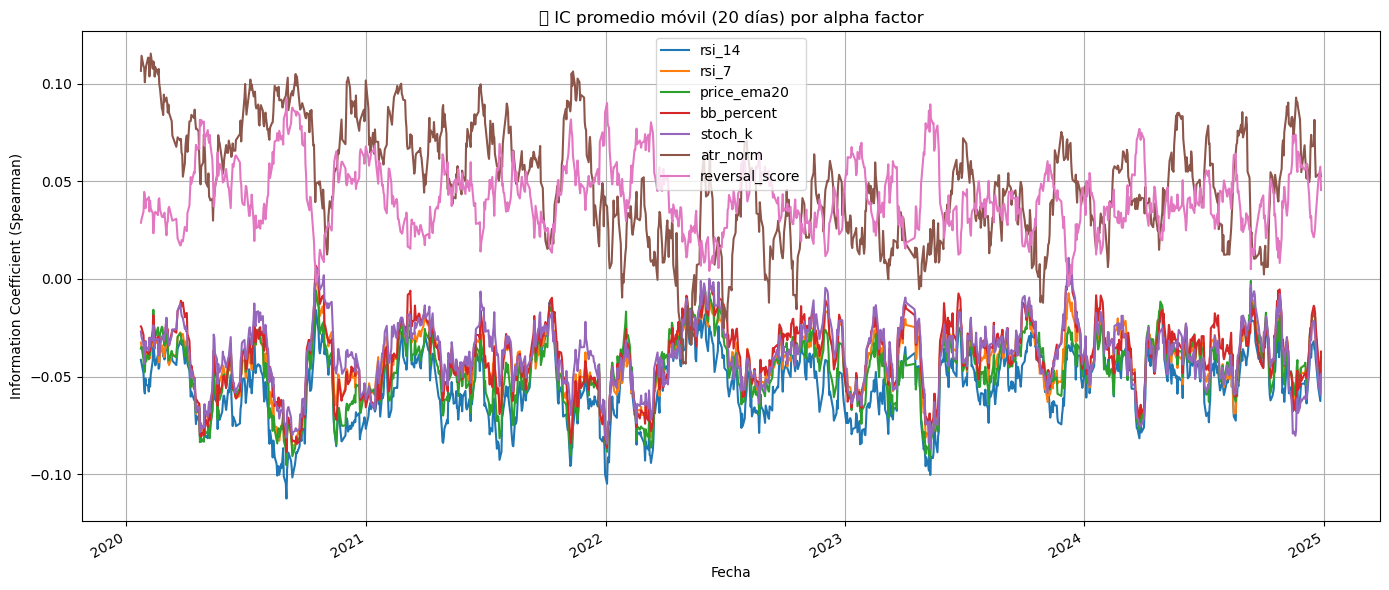

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Suponemos que ya cargaste mnq_intraday_clean con estos factores
alpha_factors = ['rsi_14', 'rsi_7', 'price_ema20', 'bb_percent', 'stoch_k', 'atr_norm', 'reversal_score']
target = 'future_return_5min'

# Agrupar por día
grouped = mnq_intraday_clean.groupby('date')

# Calcular IC diario
ic_diarios = {factor: [] for factor in alpha_factors}
fechas = []

for date, group in grouped:
    fechas.append(date)
    for factor in alpha_factors:
        df_valid = group[[factor, target]].dropna()
        if len(df_valid) >= 30:
            ic = spearmanr(df_valid[factor], df_valid[target]).correlation
        else:
            ic = np.nan
        ic_diarios[factor].append(ic)

# Convertir a DataFrame de IC diarios
df_ic = pd.DataFrame(ic_diarios, index=pd.to_datetime(fechas))

# Graficar la media móvil de 20 días
plt.figure(figsize=(14, 6))
for factor in alpha_factors:
    df_ic[factor].rolling(20).mean().plot(label=factor)

plt.title("📈 IC promedio móvil (20 días) por alpha factor")
plt.xlabel("Fecha")
plt.ylabel("Information Coefficient (Spearman)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()